# Image Features Exercise

A basic exercise to show that preprocessing features aids in classification accuracy.

## Data

Using the CIFAR-10 training data.  Expected location should be in `res/cifar-10-python/cifar-10-batches-py`.

### Load CIFAR-10 Data

In [1]:
import gbl
import os
import matplotlib.pyplot as plt
import numpy as np
X, Y = gbl.load_cifar10('res/cifar-10-python/cifar-10-batches-py')

### Plot a preview of the first 100 training data

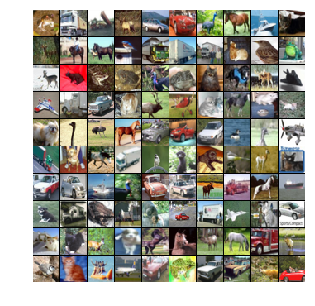

In [2]:
plt.figure(figsize=(5, 5))
gbl.plot_image(gbl.get_tile_image(X[:100], 10, 10))

## Softmax

Define the functions to train softmax regression

In [3]:
def softmax(X, w, b):
    '''Computes the softmax function.  The argmax value is the class predicted.
    
    Params:
        X (np.array): 2D array of features, i.e. can compute more than one item
        w (np.array): 2D array of weights, should be n_features by n_classes
        b (np.array): 1D array of biases, should be of size n_classes
        
    Returns:
        (np.array): 2D array of predictions, where argmax gives the class
    '''
    result = np.exp(np.dot(X, w) + b)
    result /= result.sum(-1, keepdims=True)
    return result

# The gradient step
def gradient(X, Y, w, b, alpha = 0.01):
    '''Applies a single gradient step to w and b.  Returns the updated cost.
    
    Params:
        X (np.array): A batch
        Y (np.array): 2D array of one-hot training labels
        w (np.array): 2D array of weights
        b (np.array): 1D array of biases
        alpha (float): Learning rate
        l (float): Decay parameter
        
    Returns:
        (float): The cost at the given time step.
    '''
    inv_m = 1. / len(X)
    a = softmax(X, w, b)
    d_ = a - Y
    djdw = np.dot(X.T, d_)
    djdb = d_.sum(0)
    
    w -= alpha * inv_m * djdw
    b -= alpha * inv_m * djdb
    
    return -np.sum(np.log(a) * Y) * inv_m

def compute_accuracy(X, Y, w, b):
    a = softmax(X, w, b)
    return (a.argmax(-1) == Y).sum() / len(Y)

def train(X_train, Y_train, X_test, Y_test, verbose=True):
    BATCH_SIZE = 20
    # Define weights, 10 classes, 32 * 32 * 3 weights per class.
    w = np.random.normal(0, 1e-6, (X_train.shape[-1], 10))
    b = np.random.normal(0, 1e-6, 10)

    # We use this to index our batches.  When we reach the end, we randomize, meaning we reached an epoch.
    rng = np.arange(len(Y_train))
    start, end = 0, BATCH_SIZE

    accuracy_progress = []
    cost_progress = []

    for i in range(50000):
        indices = rng[start:end]

        cost = gradient(X_train[indices], Y_train[indices], w, b, alpha=0.003)
        if i % 250 == 0:
            accuracy = compute_accuracy(X_train, Y_train.argmax(-1), w, b)
            accuracy_progress.append(accuracy)
            cost_progress.append(cost)
            if i % 1000 == 0 and verbose:
                print("Iterations: ", i, "Accuracy: ", accuracy * 100, "Cost: ", cost)

        start, end = start + BATCH_SIZE, end + BATCH_SIZE
        if start >= len(Y_train):
            start, end = 0, BATCH_SIZE
            np.random.shuffle(rng)
    return w, b, accuracy_progress, cost_progress

## Training

### Softmax without feature processing

Train using softmax regression without feature processing.  This will be used to compare against the accuracy of training when preprocessing is applied.  This might take a while.

In [4]:
# Flatten the training data and normalize linearly
X_flat = X.reshape(X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]) / X.max()
X_train = X_flat[:49000]
Y_train = np.eye(10, dtype=np.float32)[Y[:49000]]
X_test = X_flat[49000:]
Y_test = Y[49000:]

w, b, accuracy_progress, cost_progress = train(X_train, Y_train, X_test, Y_test)

Iterations:  0 Accuracy:  9.98979591837 Cost:  2.30258527335
Iterations:  1000 Accuracy:  34.0571428571 Cost:  1.94383198525
Iterations:  2000 Accuracy:  35.112244898 Cost:  1.7511565222
Iterations:  3000 Accuracy:  37.0142857143 Cost:  1.90868452836
Iterations:  4000 Accuracy:  36.5387755102 Cost:  1.57815874216
Iterations:  5000 Accuracy:  37.1816326531 Cost:  1.44355903966
Iterations:  6000 Accuracy:  36.3693877551 Cost:  1.58959575285
Iterations:  7000 Accuracy:  38.4285714286 Cost:  2.08200620706
Iterations:  8000 Accuracy:  39.4612244898 Cost:  2.19290943913
Iterations:  9000 Accuracy:  38.9693877551 Cost:  1.6829905434
Iterations:  10000 Accuracy:  38.2408163265 Cost:  1.55215931001
Iterations:  11000 Accuracy:  37.9693877551 Cost:  1.88025104789
Iterations:  12000 Accuracy:  39.2755102041 Cost:  1.35255770049
Iterations:  13000 Accuracy:  39.2326530612 Cost:  1.7859803591
Iterations:  14000 Accuracy:  38.8979591837 Cost:  1.57414380137
Iterations:  15000 Accuracy:  39.459183673

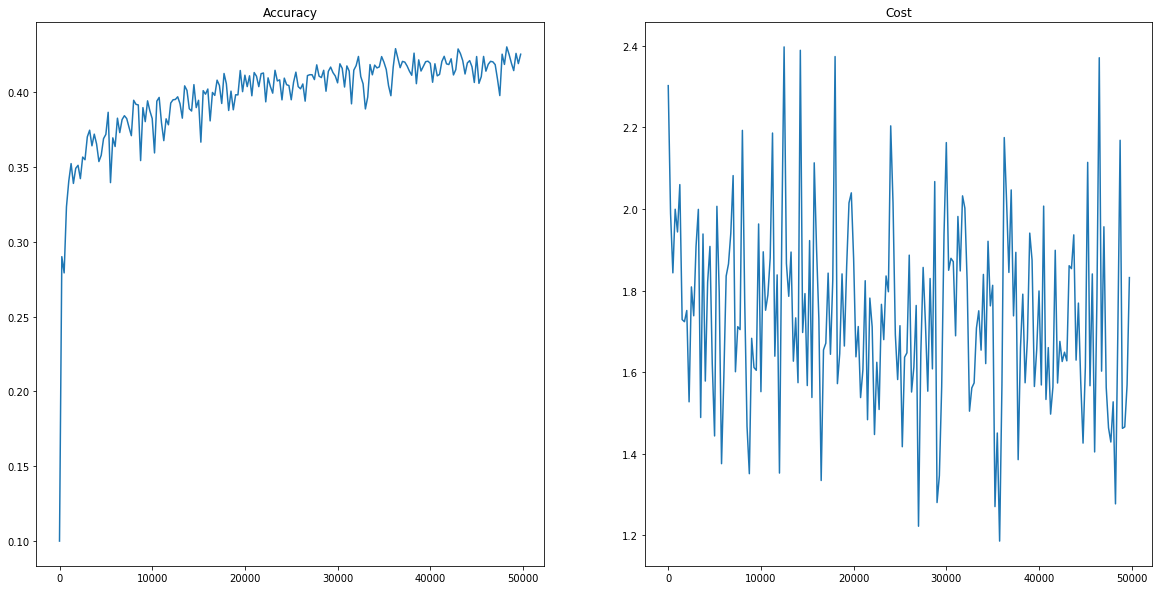

In [5]:
plt.figure(figsize=(20,10))

steps = range(0, 50000, 250)

plt.subplot(1, 2, 1)
plt.plot(steps, accuracy_progress)
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(steps, cost_progress)
plt.title('Cost')

plt.show()

The accuracy is as expected for this model.

In [6]:
print("Final training accuracy:", compute_accuracy(X_train, Y_train.argmax(-1), w, b) * 100.)
print("Validation accuracy:", compute_accuracy(X_test, Y_test, w, b) * 100.)

Final training accuracy: 41.7816326531
Validation accuracy: 39.8


### Training using HOG and HSV

We now train the model augmented with a HOG (Histogram of oriented gradients). There should be an improvement in accuracy.  

In [4]:
from skimage.feature import hog
from skimage import data, color, exposure

def get_feats(imgs):
    X_gray = np.array([color.rgb2gray(x) for x in imgs])
    X_hogs = np.array([hog(x, orientations=9, pixels_per_cell=(8,8), cells_per_block=(1,1))\
                       for x in X_gray])
    X_flat = X.reshape(X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]) / X.max()
    return np.concatenate((X_flat, X_hogs), axis=-1)
    
X_feat = get_feats(X)
X_train = X_feat[:49000]
Y_train = np.eye(10, dtype=np.float32)[Y[:49000]]
X_test = X_feat[49000:]
Y_test = Y[49000:]

w, b, accuracy_progress, cost_progress = train(X_train, Y_train, X_test, Y_test)

/usr/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Iterations:  0 Accuracy:  9.98979591837 Cost:  2.30258500804
Iterations:  1000 Accuracy:  34.7142857143 Cost:  1.93296532474
Iterations:  2000 Accuracy:  35.9734693878 Cost:  1.73202368822
Iterations:  3000 Accuracy:  38.6102040816 Cost:  1.6107318801
Iterations:  4000 Accuracy:  37.9836734694 Cost:  1.86738578861
Iterations:  5000 Accuracy:  40.3591836735 Cost:  1.52719847335
Iterations:  6000 Accuracy:  40.4265306122 Cost:  1.72835143219
Iterations:  7000 Accuracy:  38.5693877551 Cost:  1.47489049192
Iterations:  8000 Accuracy:  39.6857142857 Cost:  1.29634475649
Iterations:  9000 Accuracy:  42.4673469388 Cost:  1.93288210029
Iterations:  10000 Accuracy:  41.1857142857 Cost:  1.74101835231
Iterations:  11000 Accuracy:  43.0612244898 Cost:  1.83997980718
Iterations:  12000 Accuracy:  41.6857142857 Cost:  1.69388036447
Iterations:  13000 Accuracy:  44.012244898 Cost:  1.88785496777
Iterations:  14000 Accuracy:  42.1979591837 Cost:  1.57630088093
Iterations:  15000 Accuracy:  43.2469387

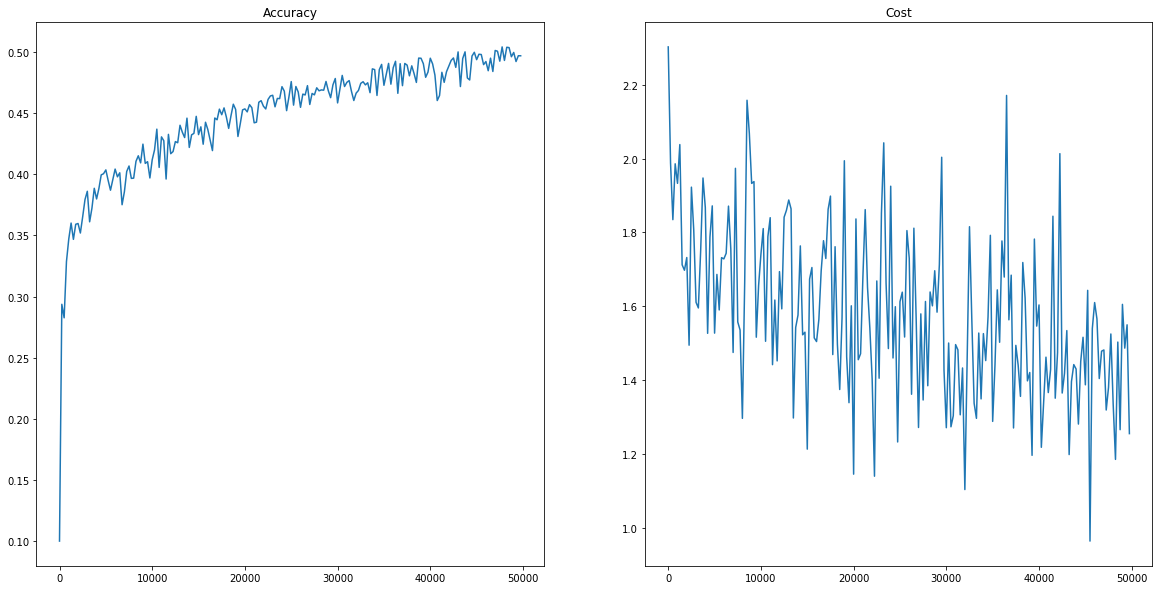

In [6]:
plt.figure(figsize=(20,10))

steps = range(0, 50000, 250)

plt.subplot(1, 2, 1)
plt.plot(steps, accuracy_progress)
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(steps, cost_progress)
plt.title('Cost')

plt.show()

In [5]:
print("Final training accuracy:", compute_accuracy(X_train, Y_train.argmax(-1), w, b) * 100.)
print("Validation accuracy:", compute_accuracy(X_test, Y_test, w, b) * 100.)

Final training accuracy: 50.4734693878
Validation accuracy: 48.4


As expected, the accuracy increased about 9%-10%.